In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"monkrld","key":"ea52c98eb19cb43a1c00e3e61f3c64dd"}'}

Install the kaggle API

In [ ]:
!pip install -q kaggle

Moving the kaggle.json file into ~/.kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!cp kaggle.json ~/.kaggle/

Downloading files

In [ ]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-dataset -p '/content'

100% 23.1G/23.1G [19:42<00:00, 22.5MB/s]
100% 23.1G/23.1G [19:42<00:00, 20.9MB/s]


In [ ]:
!unzip -q '/content/fashion-product-images-dataset.zip'

In [ ]:
!rm -rf fashion-product-images-dataset.zip

In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 6.8 MB/s eta 0:00:00


In [ ]:
!pip install torchmetrics[image]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 6.6 MB/s eta 0:00:00


In [ ]:
import torch
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from transformers import CLIPTokenizer
from sklearn.model_selection import train_test_split

In [ ]:
import sys

project_path = '/content/drive/MyDrive/Github/Product-image-generation-from-text-description'
sys.path.insert(0, project_path)

from CustomDataset import CustomTensorDataset

ModuleNotFoundError: ignored

Preprocessing

In [ ]:
!pip install -q diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.0/852.0 kB 44.2 MB/s eta 0:00:00


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
from diffusers import AutoencoderKL 
from diffusers import UNet2DConditionModel, LMSDiscreteScheduler, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
import torch

dtype = torch.float32
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=dtype).to(device)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=dtype).to(device)
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder", torch_dtype=dtype).to(device)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
noise_scheduler = DDPMScheduler(
        beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
    
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

Reading descriptions

In [ ]:
import os
import pandas as pd

project_path = '/content/drive/MyDrive/Github/Product-image-generation-from-text-description'

path_to_descriptions = os.path.join(project_path, 'descriptions.json')
descriptions = pd.read_json(path_to_descriptions, orient='records')

In [ ]:
RESOLUTION = 512

data_transformation_images = transforms.Compose([
            transforms.Resize((RESOLUTION, RESOLUTION)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, ), (0.5, ))
        ])

path = '/content/fashion-dataset/fashion-dataset/images'
batch_size = 6

dataset = CustomTensorDataset(descriptions, tokenizer, path, transform_images=data_transformation_images)

TrainTest split

In [ ]:
np.random.seed(42)
indices = np.arange(len(descriptions))
indices_train, indices_test = train_test_split(indices, test_size=0.006, random_state=42)

Creating train_dataset, test_dataset and train_loader, test_loader

In [ ]:
train_dataset = Subset(dataset, indices_train)
test_dataset = Subset(dataset, indices_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
ids = [3, 4, 7]
text_prompts = [prompt + " in style of online shop isolated on white background" for prompt in descriptions.iloc[[3, 4, 7], :]['description'].values]
print(text_prompts)

['Men Black Dial Chronograph Watch FS Winter Casual Accessories in style of online shop isolated on white background', 'Silver Ring Fall Casual in style of online shop isolated on white background', 'Women Yacho Jhuti Pink Belt Winter Casual Accessories in style of online shop isolated on white background']


In [ ]:
from tqdm import tqdm 

def generate_images(text_prompts, vae, unet, noise_scheduler, text_encoder, tokenizer, im_height=512, im_width=512):
    noise_scheduler.set_timesteps(70)
    text = [tokenizer(text_prmt, padding="max_length", 
                                max_length=tokenizer.model_max_length, truncation=True,
                                return_tensors="pt")["input_ids"] for text_prmt in text_prompts]
    text = torch.cat(text)
    batch_size = text.shape[0]

    with torch.no_grad():
        text_embeddings = text_encoder(text.to(device))[0].to(dtype=dtype)#.half()

    latents = torch.randn((batch_size, unet.in_channels, im_height // 8, im_width // 8))
    latents = latents.to(device).to(dtype=dtype)#.half() #* noise_scheduler.init_noise_sigma
    latents = latents * vae.config.scaling_factor 

    for t in tqdm(noise_scheduler.timesteps):
        latent_model_input = noise_scheduler.scale_model_input(latents, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # compute the previous noisy sample x_t -> x_t-1
        latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

    latents = 1 / vae.config.scaling_factor * latents

    with torch.no_grad():
        images = vae.decode(latents).sample

    images = (images / 2 + 0.5).clamp(0, 1)
    images = images.detach().cpu().permute(0, 2, 3, 1).numpy()
    return images

In [ ]:
links = {}
for file in os.listdir(path):
    links[int(file.split('.')[0])] = path + '/' + file

In [ ]:
images = generate_images(text_prompts, vae, unet, noise_scheduler, text_encoder, tokenizer, im_height=256, im_width=256)

In [ ]:
links = {}
path = '/content/fashion-dataset/images'

for file in os.listdir(path):
    links[int(file.split('.')[0])] = path + '/' + file

In [ ]:
idx = descriptions.iloc[[3, 4, 7]]['id']

In [ ]:
from PIL import Image

Image.open(links[idx[3]]).resize((256, 256))

Text(0.5, 1.0, 'Men Black Dial Chronograph Watch FS Winter Casual Accessories in style of online shop isolated on white background')

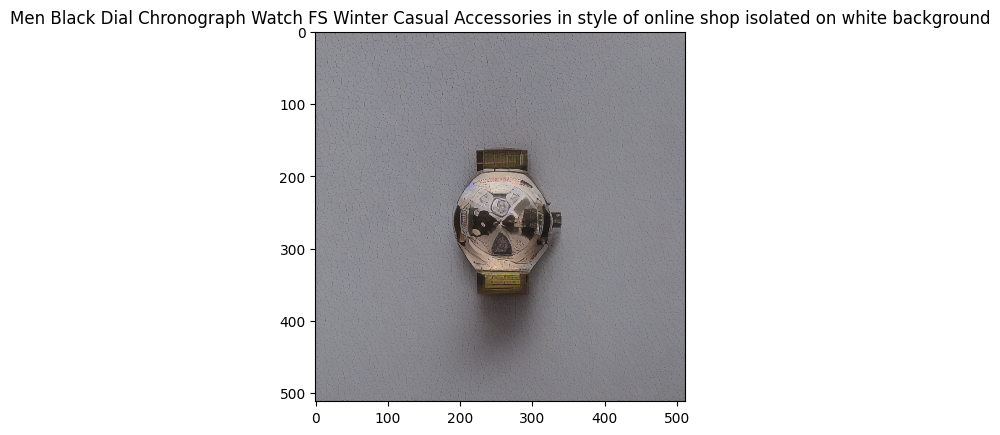

In [ ]:
import matplotlib.pyplot as plt

plt.imshow((images * 255).astype("uint")[0])
plt.title(text_prompts[0])

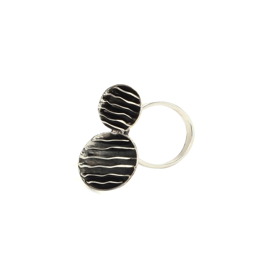

In [ ]:
Image.open(links[idx[4]]).resize((256, 256))

Text(0.5, 1.0, 'Silver Ring Fall Casual in style of online shop isolated on white background')

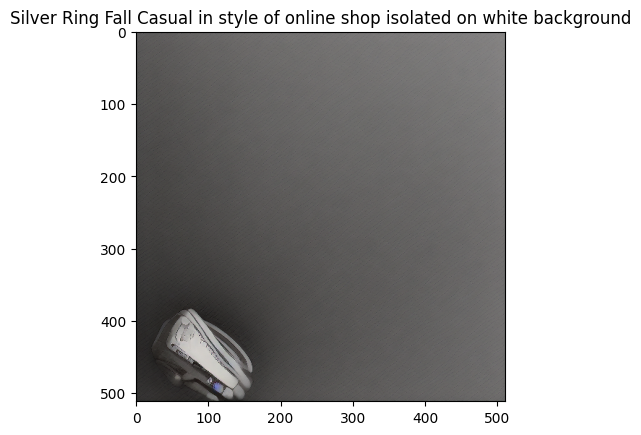

In [ ]:
plt.imshow((images * 255).astype("uint")[1])
plt.title(text_prompts[1])

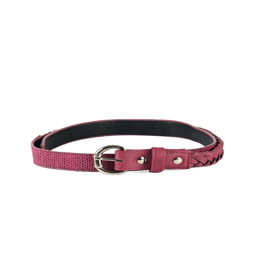

In [ ]:
Image.open(links[idx[7]]).resize((256, 256))

Text(0.5, 1.0, 'Women Yacho Jhuti Pink Belt Winter Casual Accessories in style of online shop isolated on white background')

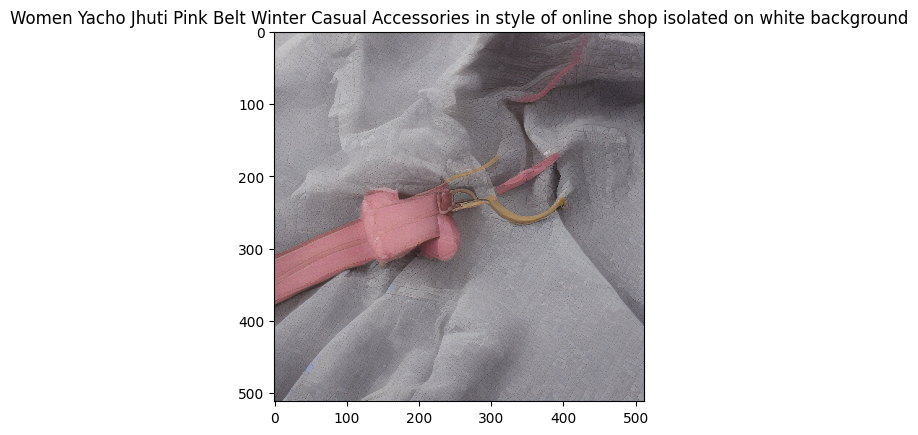

In [ ]:
plt.imshow((images * 255).astype("uint")[2])
plt.title(text_prompts[2])

In [ ]:
from tqdm import tqdm
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from PIL import Image


def test(vae, unet, noise_scheduler, text_encoder, dataloader,num_inference_steps, device, logger, height=512, width=512):

    unet.eval()
    vae.eval()
    text_encoder.eval()
    noise_scheduler.set_timesteps(num_inference_steps, device=device)
    
    num_images_to_log = 10
    num_iters = (num_images_to_log / dataloader.batch_size) + 1


    # specifying metric
    fid = FrechetInceptionDistance(feature=64)
    metric_fid = 0.0
    inception_score = InceptionScore(feature=64)    
    metric_inception = 0.0
    for idx, batch_data in tqdm(enumerate(dataloader)):
        text, images = batch_data
        images = images.to(device)
        with torch.no_grad():
            text_embeddings = text_encoder(text["input_ids"].squeeze(1).to(device))[0]
        batch_size = images.shape[0]

        latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8))
        latents = latents * vae.config.scaling_factor
        latents = latents.to(device)
        
        for t in noise_scheduler.timesteps:
            latent_model_input = noise_scheduler.scale_model_input(latents, t)

            # predict the noise residual
            with torch.no_grad():
                with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=True):
                    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # compute the previous noisy sample x_t -> x_t-1
            latents = noise_scheduler.step(noise_pred, t, latents).prev_sample
        
        latents = 1 / vae.config.scaling_factor * latents

        with torch.no_grad():
            with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=True):
                pred_images = vae.decode(latents).sample
        
        if idx < num_iters:
            images_pred = (pred_images / 2 + 0.5).clamp(0, 1)
            images_pred = images_pred.cpu().permute(0, 2, 3, 1).float().numpy()
            true_images = (images / 2 + 0.5).clamp(0, 1).cpu().permute(0, 2, 3, 1).float().numpy()
            image_array = [(true_images[i] * 255).astype(np.uint8) for i in range(true_images.shape[0])]
            images_pred = [(images_pred[i] * 255).astype(np.uint8) for i in range(images_pred.shape[0])]
            
            lbl_idx = idx * dataloader.batch_size
            indices = dataloader.dataset.indices
            labels = [dataloader.dataset.dataset.descriptions.iloc[indices[lbl_idx + i]]['description'] for i in range(true_images.shape[0])]
            
            true_images = [Image.fromarray(image) for image in image_array]
            images_pred = [Image.fromarray(image) for image in images_pred]
            logger.log({"true_images": [wandb.Image(image, caption=labels[i]) for i, image in enumerate(true_images)],
                      "pred_images": [wandb.Image(image, caption=labels[i]) for i, image in enumerate(images_pred)]})

        # compute metrics
        # FID
        fid.update(images.type('torch.ByteTensor'), real=True)
        fid.update(pred_images.type('torch.ByteTensor'), real=False)
        metric_fid += fid.compute().item()
        # Inception Score
        inception_score.update(pred_images.type('torch.ByteTensor'))
        metric_inception += inception_score.compute()[0].item()

    return metric_fid/ len(dataloader), metric_inception / len(dataloader)


In [ ]:
# fid = test(vae, unet, noise_scheduler, text_encoder, test_loader, 50, device)

45it [18:43, 24.96s/it]


In [ ]:
# fid

4.513091325759888

In [ ]:
!pip install --upgrade -q wandb
!pip install wandb login

In [ ]:
import wandb


wandb.login()
run = wandb.init(project='text-to-image',
                    group='finetune',
                    entity = 'datasatanists', #resume='must',
                    job_type='train')

In [ ]:
fid, inception_score = test(vae, unet, noise_scheduler, text_encoder, test_loader, 50, device, wandb)
print(f"FID: {fid}, Inception Score: {inception_score}")

/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
32it [13:41, 25.50s/it]

In [ ]:
inception_score

1.010667422082689

In [ ]:
# torch.cuda.empty_cache()